<a href="https://colab.research.google.com/github/christinacdl/Thesis_Detection_of_Offensive_Language/blob/main/Offensive_Language_Detection_in_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OFFENSIVE LANGUAGE DETECTION IN TWEETS USING MACHINE LEARNING METHODS**

**National and Kapodistrian University of Athens**

**Department of Informatics and Telecommunications**

**Program of Postgraduate Studies: Language Technology**

**Master's Thesis**

**Christodoulou Christina**




## **ABSTRACT**
---

Undoubtedly, offensive language has become ubiquitous in social media over the last years due to the increasing popularity of social media platforms. The growing number of users that tend to post offensive content targeting individuals or groups has led to significant repercussions not only for the well-being of the targets, but also for society itself. This has raised concern in governments, social media companies as well as academic and social communities, who have made concerted efforts to curb the dissemination of offensive language online and create a safer digital space. Nevertheless, despite their endeavors, the need to rapidly process huge amounts of content in order to detect and report offensive language has made the development of machine learning systems more than imperative. Consequently, in the present thesis, three different machine learning models, which perform binary text classification, are introduced to detect offensive language in English texts from Twitter. The proposed models, which constitute two simple classifiers and a Bidirectional Stacked LSTM, utilize contextual embeddings pooled from BERT-LARGE-Uncased by fine-tuning its various layers on four training datasets combined in one. The data preparation process involved data cleaning and preprocessing as well as data down-sampling to handle class imbalance. The effectiveness of the proposed methods is evaluated on two available test sets, OLID 2019 and OLID 2020, based on six metrics, the learning curves of loss and accuracy as well. Comparative analysis between those methods demonstrates that the concatenation of the last four hidden layers of BERT fed in a classifier outperforms the other models by achieving 77.8% and 86.8% Macro-F1 scores in the two test sets respectively. Comparison with previous related methods indicates that, although the results are satisfactory, there is room for further experimentation and improvement in the future. 


**KEYWORDS:**

Offensive Language Detection, Machine Learning, Deep Learning, Natural Language Processing, NLP, Text Classification, Twitter, Social Media 


In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
'''
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import sys

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
'''

#drive.mount('/content/drive')
#sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/THESIS')

'\n!pip install -U -q PyDrive\nfrom pydrive.auth import GoogleAuth\nfrom pydrive.drive import GoogleDrive\nfrom google.colab import auth\nfrom oauth2client.client import GoogleCredentials\nfrom google.colab import drive\nimport sys\n\n# Authenticate and create the PyDrive client.\n# This only needs to be done once per notebook.\nauth.authenticate_user()\ngauth = GoogleAuth()\ngauth.credentials = GoogleCredentials.get_application_default()\ndrive = GoogleDrive(gauth)\n'

In [1]:
!pip install torchtext transformers emoji unidecode ekphrasis -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 7.5 MB/s 
     |████████████████████████████████| 216 kB 59.9 MB/s 
     |████████████████████████████████| 235 kB 79.2 MB/s 
     |████████████████████████████████| 83 kB 3.0 MB/s 
     |████████████████████████████████| 7.6 MB 73.3 MB/s 
     |████████████████████████████████| 163 kB 77.0 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=eb03bfafcea6a07c012f78dd4530fb211dbe85de6f523cb6a7b50176d8a5a42e
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [2]:
# Import necessary libraries
import argparse
import torch
from torchtext import data, datasets
import random
import re 
import glob 
import spacy
import string 
import time
import emoji
import pandas as pd  
import seaborn as sns
import math
import numpy as np
import nltk
from tqdm import tqdm, trange
import datetime
import torch.nn as nn
import torch.optim as optim
import collections
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  matthews_corrcoef
from sklearn.metrics import classification_report
from functools import reduce
import os
import copy
from bs4 import BeautifulSoup
import itertools
from unidecode import unidecode
from collections import OrderedDict
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from torch.utils.data import Dataset, DataLoader 
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertModel,BertConfig, AlbertConfig, AlbertModel, AlbertTokenizer, RobertaModel, RobertaTokenizer, RobertaConfig
import matplotlib.pyplot as plt 
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer

In [3]:
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [4]:
# Set up GPU for Training
if torch.cuda.is_available():       
  device = torch.device('cuda')
  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print('Device name:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: Tesla T4


**THE LABELS**

In [5]:
# Determine the number of labels in the data and map each of these labels to an index. There are 2 labels: Not Offensive (NOT) and Offensive (OFF)
labels = {'NOT': 0 ,'OFF': 1}
print(labels)

{'NOT': 0, 'OFF': 1}


**FUNCTIONS USED**

In [6]:
# A function that sets seed for reproducibility
def set_seed(seed_value): 
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)


# A function that calculates time in seconds and returns a string in the form hh:mm:ss
def calculate_time(elapsed_time):  
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed_time)))  
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# A function that calculates the trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# A function that checks if a directory exists else creates the directory 
def check_create_path(path): 
  if not os.path.exists(path):
    os.makedirs(path)
    print('Directory created at {}'.format(path))
  else:
    print('Directory {} already exists!'.format(path))


# A function that reads a csv or tsv file, removes missing values and duplicates 
def read_a_file(filename):
  
  # Check first whether a certain file or directory exists
  if os.path.exists(filename):
    print('Current file opened: ',[os.path.join(filename, file) for file in glob.glob(filename)])
    
    # Find the file extension to open it properly
    find_separator = {'.csv': ',', '.tsv': '\t'}
    basename, format = os.path.splitext(filename)
    assert format in find_separator
    separator = find_separator[format]

    # Read different extensions of files using pandas with 2 different separators     
    read_file = pd.read_csv(filename, sep = separator, encoding = 'utf-8')
      
    # Get the keys and their corresponding number of values
    keys = read_file.keys() 
    for key in keys:
      df_len = len(read_file[key].unique()) # the length of the unique values of each column
      print('{0:25}{1:10}'.format(key,df_len))

    # Remove missing values and keep the dataFrame with valid entries in the same variable
    read_file.dropna(inplace = True) 
      
    # Remove the index
    read_file.reset_index(inplace = True, drop = True)

    read_file.info()
        
    return read_file

  else:
    print('File or directory not accessible. Please check the entered path of the file.')

In [7]:
# MY FUNCTIONS FOR DATA PREPROCESSING

def emojis_into_text(sentence):
  demojized_sent = emoji.demojize(sentence)
  emoji_txt = re.sub(r':[\S]+:', lambda x: x.group().replace('_', ' ').replace('-', ' ').replace(':', ''), demojized_sent)
  return emoji_txt 


text_processor = TextPreProcessor(
    # terms that will be normalized
    #normalize = ['user'],
    # terms that will be annotated
    annotate = {'hashtag'},
    #'allcaps', 'repeated', 'elongated'}, 
     
    # corpus from which the word statistics are going to be used for word segmentation 
    segmenter = 'twitter', 
    
    # corpus from which the word statistics are going to be used for spell correction
    corrector = 'twitter', 

    fix_html = True,  # fix HTML tokens
    fix_text = True,
    unpack_hashtags = True,  # perform word segmentation on hashtags
    unpack_contractions = True,  # Unpack contractions (can't -> can not)
    spell_correct_elong = True,  # spell correction for elongated words
    
    tokenizer = SocialTokenizer(lowercase = True).tokenize)


def preprocessing(text):
 
  try:   # Remove the UTF-8 BOM (Byte Order Mark)
    text = text.decode('utf-8-sig').replace(u'\ufffd', '?') # The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8
  except:
    text = text
  
  # HTML encoding
  soup = BeautifulSoup(text,'lxml') #HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc.
  text = soup.get_text()    
  
  # Replace the RT with whitespace 
  text = re.sub('RT @\w+: ','', text)
  
  # Remove the @user tags  
  text = re.sub(r'@[A-Za-z0-9_]+','', text)
  
  # Remove the url links
  text = re.sub(r'http(s?)://[\S]+','', text)
  
  # Remove the 'url' and 'html' word
  url_words = ['url', 'URL', 'html', 'HTML', 'http', 'HTTP']   
  for u in url_words:  
    text = re.sub(u,'', text)
  
  # Convert the emojis into their textual representation
  text = emojis_into_text(text)
    
  # Replace '&amp;' with 'and'
  text = re.sub(r'&amp;','and', text)
  text = re.sub(r'&','and', text)
 
  # Replace the unicode apostrophe 
  text = re.sub(r"’","'", text)
  
  # Replace consecutive non-ASCII characters with whitespace
  text = re.sub(r'[^\x00-\x7F]+',' ', text)     

  # Remove the extra whitespace 
  text = re.sub(r'\s+', ' ', text)

  # Apply the text processor from ekphrasis library
  text = " ".join(text_processor.pre_process_doc(text))
 
  return text


# Reads in file and returns a list of curse words
def read_csv_curse_words():
  curse_words = []
  f = open('/content/drive/MyDrive/ColabNotebooks/THESIS/noswearingclean.csv', 'r')
  translator = str.maketrans('', '', string.punctuation)
  for line in f:
    line = line.strip()
    line = line.split(",")
    word = line[0].translate(translator)
    curse_words.append(word)
  f.close()
  return curse_words


# Binary search for list of words
def find(L, target):
  start = 0
  end = len(L) - 1
  while start <= end:
    middle = (start + end) // 2
    midpoint = L[middle]
    if midpoint > target:
      end = middle - 1
    elif midpoint < target:
      start = middle + 1
    else:
      return True
  return False


# Returns a list of regexes
def read_regex():
  re_str = []
  # Read in the lines from the regex input file.
  with open('/content/drive/MyDrive/ColabNotebooks/THESIS/regexes.txt', 'r') as f:
    for line in f:
      re_str.append(line.split('\n')[0])
  f.close()

  # From each regex string, create a tuple of the compiled regex and the dictionary-
  # accurate label (i.e., what variants caught by that regex should be treated as)
  regexes = []
  for variant in re_str:
    expr, label = variant.split(',')
    regexes.append((re.compile(expr), label.strip()))
  return regexes


# Checks if word matches a regex and returns an empty string for no match and the collapsed word for a match
def check_regex(word, regexes):
  for expr in regexes:
    if bool(re.fullmatch(expr[0], word)):
      return expr[1]
  return ""


# Reads in file and creates dataframe
def find_offensive_words(dataframe):

  # Find the file extension to open it properly
  find_separator = {'.csv': ',', '.tsv': '\t'}
  basename, format = os.path.splitext(dataframe)
  assert format in find_separator
  separator = find_separator[format]

  training_dataset = pd.read_csv(dataframe, sep = separator, encoding = 'utf-8') 
  tweets = training_dataset['tweet'].astype(str)
  curse_words = read_csv_curse_words()
  regex_list = read_regex()
  total_rows = training_dataset.shape[0]  # Total number of rows
  swear_dict = {}  # Dictionary of swear words
  count_vulgar_tweets = 0

  for i in range(total_rows):
    text = unidecode(tweets[i])
    text = re.sub(r'\s+', ' ', text).strip()
    vulgar = False     
    social_tokenizer = SocialTokenizer(lowercase = False).tokenize  
    words = social_tokenizer(text) 
    insert_words = copy.deepcopy(words)
    insert_idx = []

    for j in range(len(words)):
      if words[j] == '<hashtag>' or words[j] == '</hashtag>':
        pass
      else:  
        stripped_word = words[j]
        # If word is a dictionary match
        if find(curse_words, stripped_word):
          vulgar = True
            
          # Add swear words to dictionary
          if stripped_word in swear_dict:
            swear_dict[stripped_word] += 1
          else:
            swear_dict[stripped_word] = 1
      
          insert_words[j] = stripped_word      
          insert_idx.append(j)

        else:
          # If not a dictionary match, check if regex match
          regex_word = (check_regex(stripped_word, regex_list))
          
          if regex_word != '':
            vulgar = True
            insert_idx.append(j)        
            if regex_word in swear_dict:
              swear_dict[regex_word] += 1            
              insert_words[j] = regex_word               
            else:
              swear_dict[regex_word] = 1
                  
          # If not a regex match, word is not vulgar  
          else:
            insert_words[j] = stripped_word

    num_vulgar = len(insert_idx)

    if vulgar:
      count_vulgar_tweets += 1
      if num_vulgar == 1:
        insert_words.insert(insert_idx[0] + 1, '<OFF>')
      else:
        add_idx = 1
        for k in range(num_vulgar):
          insert_idx[k] += add_idx
          add_idx += 1
        for k in insert_idx:
          insert_words.insert(k, '<OFF>')
      
    training_dataset.at[i, 'tweet'] = ' '.join(insert_words)  
    
  word_stats_sorted = OrderedDict(sorted(swear_dict.items(), key = lambda x: x[1], reverse = True))
  word_stats_sorted = list(word_stats_sorted.items())

  print('Total number of offensive tweets: {}'.format(count_vulgar_tweets))
  print('Total number of tweets: {}'.format(total_rows))
  print('Percent offensive: {} %'.format(round((count_vulgar_tweets/total_rows) * 100, 3)))
  print('-----------------------------------------------------------------')
  print('Top 10 words')
  for i in range(10):
    print(word_stats_sorted[i][0], ':', word_stats_sorted[i][1])
 
  return training_dataset


def select_to_get_offensive_words(file_directory, search_offensive_vocab = True):

  if search_offensive_vocab:
    print('Reading the file and searching for offensive vocabulary...')
    dataset = find_offensive_words(file_directory)
  else:
    print('Reading the file...')
    dataset = read_a_file(file_directory)
  return dataset

Word statistics files not found!
Downloading... 

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [8]:
# A function that splits the data into training and validation
def data_splitting(dataframe, text_column, label_column, split_ratio):

  x_train_texts, y_val_texts, x_train_labels, y_val_labels = train_test_split(dataframe[text_column], dataframe[label_column], 
                                                                              random_state = 42, 
                                                                              test_size = split_ratio, 
                                                                              stratify = dataframe[label_column])
  print('Shape of x_train: ', x_train_texts.shape)
  print('Shape of y_train: ', x_train_labels.shape)
  print('Shape of x_validation:  ', y_val_texts.shape)
  print('Shape of y_validation:  ', y_val_labels.shape)

  return x_train_texts, y_val_texts, x_train_labels, y_val_labels


# A class that creates the necessary input for a pretrained model 
class Data_Preparation(Dataset):
  
  def __init__(self, tweet, label, tokenizer, max_len):  
    self.tweet = tweet
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
        
  def __len__(self):  
    return len(self.tweet)

  def __getitem__(self, index): 

    tweet = str(self.tweet[index])
    tweet = " ".join(tweet.split())

    encoding = self.tokenizer.encode_plus(text = tweet,
                                          text_pair = None,
                                          add_special_tokens = True,      # Add [CLS] and [SEP]
                                          max_length = self.max_len,      # Max length to pad
                                          padding = 'max_length',         # Pad sentence according to max length  'max_length'
                                          truncation = True,              # Truncate the sentences
                                          return_token_type_ids = False,  # Do not return the ids of type tokens
                                          return_attention_mask = True,   # Return attention mask
                                          return_tensors = 'pt')          # Return PyTorch tensor
 
    if self.label is None:
      return {'input_ids': encoding['input_ids'].flatten(),  
              'attention_mask': encoding['attention_mask'].flatten()}
              
              
    else:
      return {'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten(),
              'label': torch.tensor(self.label[index], dtype = torch.float)}
    

def create_data_loader(df, tokenizer, max_len, batch_size, shuffle):
  
  data = Data_Preparation(tweet = df.tweet.to_numpy(),
                          label = df.label.to_numpy(),
                          tokenizer = tokenizer,
                          max_len = max_len)

  return DataLoader(data, batch_size = batch_size, pin_memory = True, shuffle = shuffle)

- The `train_test_split` function from sklearn is used. 
- The text from the text column of the dataframe is given so as to uniquely identify each text sample.
- The random split is based on the text and its label.
- The data is split into a larger proportion for training and a smaller for validation in order to provide more data for training but adequate data for evaluation.
- The `random_state` ensures that the splits that are generated are reproducible. Scikit-learn uses random permutations to generate the splits. The random state that is provided is used as a seed to the random number generator. This ensures that the random numbers are generated in the same order. When the `Random_state` is not defined in the code for every run, the train data will change and the metrics might change for every run. When the `Random_state` = _"constant integer"_ is defined, then the train data will be constant for every run so that it will facilitate debugging.
- The `stratify` is used to ensure that both the training and the validation datasets contain the same percentage of classes. 



In [9]:
# A function that performs data splitting and creation of dataloaders
def TweetSplitDataPreparation(dataframe, split_ratio, tokenizer, max_length, batch_size, split_data = True, make_dataloaders = True):

  if split_data:
    train_texts, validation_texts, train_labels, validation_labels = data_splitting(dataframe, 'tweet', 'label', split_ratio = split_ratio)

    # Create a train and validation dataframe with texts and their labels 
    train_df = pd.concat([train_texts,train_labels], axis = 1)
    validation_df = pd.concat([validation_texts,validation_labels], axis = 1 )
    print('Dataset split into train and validation sets using {} split ratio.'.format(split_ratio))

    # Save the dataframes into tsv form for future use
    #train_df.to_csv(args['train_data_directory'] + 'my_training_set.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')
    #val_df.to_csv(args['train_data_directory'] + 'my_validation_set.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')
    #print('\nTrain and validation data saved in tsv form for future use.')

    if make_dataloaders:
      train_dataloader = create_data_loader(df = train_df, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size, shuffle = True)
      val_dataloader = create_data_loader(df = validation_df, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size, shuffle = False) 
      print('The train and validation dataloaders are ready for training and evaluation.')
      return train_dataloader, val_dataloader
    else:
      return train_df, validation_df
   
  else:    
    train_dataloader = create_data_loader(df = dataframe, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size, shuffle = True)
    val_dataloader = None
    print('The dataframe is not split into train and validation sets.The dataframe converted to train dataloader for training.')
    return train_dataloader, val_dataloader

In [10]:
# A function that saves a pretrained model
def save_model(model, experiment_name, model_output_dir): 
  if not os.path.exists(model_output_dir):
    os.makedirs(model_output_dir)
  output_model_file = os.path.join(model_output_dir, experiment_name)
  model_to_save = model.module if hasattr(model, 'module') else model # Take care of distributed/parallel training
  torch.save(model_to_save.state_dict(), output_model_file)
  torch.save(model_to_save, output_model_file)
  #print('Model saved to {} as {}'.format(model_output_dir, experiment_name))

# A function that loads a pretrained model
def load_saved_model(defined_model, experiment_name, model_output_dir):
  saved_model_path = os.path.join(model_output_dir, experiment_name)
  if experiment_name.endswith('.pth'):
    loaded_model = defined_model.load_state_dict(torch.load(saved_model_path))
    print('Model loaded successfully')
  if experiment_name.endswith('.pt'):
    loaded_model  = torch.load(saved_model_path)
    print('Model loaded successfully') 
  else:
    print('No such model found.') 
  return loaded_model 

In [11]:
#=== METRICS CALCULATION ===

# Calculates the accuracy per batch, used in the train_model and evaluate_model functions 
def accuracy(preds, y_true):
  probs = torch.sigmoid(preds.unsqueeze(-1))
  soft_probs = (probs > 0.5).long()
  acc = (soft_probs.squeeze() == y_true).float().mean()
  return acc


def plot_roc_curve(true, preds): 
  fpr, tpr, threshold = metrics.roc_curve(true, preds)
  roc_auc = metrics.auc(fpr, tpr)
  lw = 2
  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()


# A function that plots the confusion matrix with colors and titles 
def show_confusion_matrix(true, predicted, class_names):
  cm = confusion_matrix(true, predicted, normalize='all')
  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  ax = sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='Blues', cbar=False)
  ax.set_title('Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  # Ticket labels - List must be in alphabetical order
  ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right')
  ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=30, ha='right')
  # Display the visualization of the Confusion Matrix.
  plt.show()


def show_confusion_matrix1(true, predicted, class_names):
  cm = confusion_matrix(true, predicted, normalize='all')
  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  ax = sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='d', cmap='Blues', cbar=False)
  ax.set_title('Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  # Ticket labels - List must be in alphabetical order
  ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right')
  ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=30, ha='right')
  # Display the visualization of the Confusion Matrix.
  plt.show()


# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, preds):  
  print('\nCalculating metrics...')
  assert len(preds) == len(y_true)

  # Calculate the accuracy of the model 
  acc = accuracy_score(y_true, preds)

  # Calculate the Matthews Correlation Coefficient  
  # -1 indicates total disagreement between predicted classes and actual classes
  # 0 is synonymous with completely random guessing
  # 1 indicates total agreement between predicted classes and actual classes
  mcc = matthews_corrcoef(y_true, preds)

  # Calculate model's metrics
  model_f1_score = f1_score(y_true, preds, average = 'macro')
  model_precision = precision_score(y_true, preds, average = 'macro')
  model_recall = recall_score(y_true, preds, average = 'macro')
  
  # Calculate general precision, recall, F1 score of each class
  precision, recall, fscore, support = score(y_true, preds)
  print('Accuracy: {}'.format(acc))
  print('F1 score: {}'.format(model_f1_score))
  print('Precision: {}'.format(model_precision))
  print('Recall : {}'.format(model_recall))
  print('Matthews Correlation Coefficient: {}'.format(mcc))
  print('\nPrecision of each class: {}'.format(precision))
  print('Recall of each class: {}'.format(recall))
  print('F1 score of each class: {}'.format(fscore))
  print('Support: {}'.format(support))

  # Print the classification report
  class_names = ['NOT', 'OFF']
  print(classification_report(y_true, preds, target_names = class_names))
  
  # Create the confusion matrix 
  show_confusion_matrix(y_true, preds, class_names)

  show_confusion_matrix1(y_true, preds, class_names)

  # Plot the Receiver Operating Characteristic (ROC curve)
  plot_roc_curve(y_true, preds)

In [12]:
# A function that evaluates a trained model
def test(model, test_dataloader):
    
  print('Predicting labels for {} test sentences...'.format(len(test_dataloader)))
  
  # Initialize empty lists to store the true values and the predicted values
  true_labels = []
  predictions = []

  model.eval()

  with torch.no_grad():
  
    for batch in tqdm(test_dataloader, desc = 'Evaluation iteration'):   
      input_ids = batch['input_ids'].to(device)
      attention_masks = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      
      # Get the predictions
      outputs = model(input_ids, attention_masks)

      predictions += torch.round(torch.sigmoid(outputs)).flatten().cpu().numpy().tolist()
      true_labels += labels.flatten().cpu().numpy().tolist()

  # Calculate the metrics to evaluate model performance
  calculate_metrics(true_labels, predictions)

  return true_labels, predictions

**NECESSARY & IMPORTANT PARAMETERS**

In [13]:
dict_bert_model_names = {1: 'bert-base-uncased',
                         2: 'bert-large-uncased'} 
                    
dict_albert_model_names = {1: 'albert-base-v1',
                           2: 'albert-base-v2',
                           3: 'albert-xlarge-v1',
                           4: 'albert-xlarge-v2',
                           5: 'albert-xxlarge-v1',
                           6: 'albert-xxlarge-v2'}

dict_roberta_model_names = {1: 'roberta-base',
                            2: 'roberta-large'} 

cell_types = {1: 'LSTM',
              2: 'GRU'}                 
                           
args = {'task_name': 'Offensive Language Detection in Tweets using Machine Learning Methods',
        'train_data_directory': '/content/drive/MyDrive/ColabNotebooks/THESIS/train_files/',
        'test_data_directory': '/content/drive/MyDrive/ColabNotebooks/THESIS/test_files/',
        'output_model_directory': '/content/drive/MyDrive/ColabNotebooks/THESIS/Models_dir/BERT-Classifier_1/', 
        'model_type':  'bert',   # Write the model's name (Bert/Albert/Roberta)
        'model_name': str(dict_bert_model_names[2]),   # Change the index to train with the model of your choice   
        'cache_dir': 'cache/',
        'num_classes': 1,   # Binary classification      
        'cell_type': str(cell_types[1]),   # Change the index to train with the model with the RNN cell type of your choice 
        'num_layers': 2,  
        'dropout': 0.1,
        'max_seq_length': 280,   
        'data_split_ratio': 0.2,  
        'batch_size': 12,  
        'num_train_epochs': 10,
        'warmup_steps': 0,  
        'max_grad_norm' : 1.0, 
        'weight_decay':  0.01,   # Weight decay is a form of regularization to lower the chance of overfitting 
        'learning_rate': 2e-5,   # Suggested learning rates for BERT fine-tuning: 2e-5, 3e-5, 5e-5
        'adam_epsilon': 1e-2,    # The bias correction term (Default: 1e-8)
        'seed': 42}

print('================',str(args['task_name']),'================\n')

# Get the directory names and the specific model used 
print('Output directory: ' + str(args['output_model_directory']))
print('Model Name: ' + str(args['model_name']))
args['output_specific_model_dir'] = args['output_model_directory'] + args['model_name'] + '/'
print('Output Directory: ' + str(args['output_specific_model_dir']))

# Check whether the directories exist else create them
print('\nChecking that the necessary paths exist...')
check_create_path(args['train_data_directory'])
check_create_path(args['test_data_directory'])
check_create_path(args['output_model_directory'])
check_create_path(args['output_specific_model_dir'])

MODEL_CLASSES = {'bert': (BertConfig, BertModel, BertTokenizer),
                 'albert': (AlbertConfig, AlbertModel, AlbertTokenizer),
                 'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer)}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

================ Offensive Language Detection in Tweets using Machine Learning Methods ================

Output directory: /content/drive/MyDrive/ColabNotebooks/THESIS/Models_dir/BERT-Classifier_1/
Model Name: bert-large-uncased
Output Directory: /content/drive/MyDrive/ColabNotebooks/THESIS/Models_dir/BERT-Classifier_1/bert-large-uncased/

Checking that the necessary paths exist...
Directory /content/drive/MyDrive/ColabNotebooks/THESIS/train_files/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/THESIS/test_files/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/THESIS/Models_dir/BERT-Classifier_1/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/THESIS/Models_dir/BERT-Classifier_1/bert-large-uncased/ already exists!


**INITIALIZE THE PRETRAINED MODEL AND ITS TOKENIZER**

In [14]:
# Set seed for reproducibility
set_seed(args['seed'])

config = config_class.from_pretrained(args['model_name'], 
                                      num_labels = args['num_classes'],                                     
                                      finetuning_task = args['task_name']) 

tokenizer = tokenizer_class.from_pretrained(args['model_name'],
                                            do_lower_case = False)

tokenizer.add_tokens(['<OFF>', '<hashtag>', '</hashtag>'], special_tokens = True)

the_pretrained_model = model_class.from_pretrained(args['model_name'], 
                                                   num_labels = args['num_classes'], # The number of output labels
                                                   output_attentions = False,        # Whether the model returns attentions weights
                                                   output_hidden_states = True)      # Whether the model returns all hidden-states

# If model is BIDIRECTIONAL_RNN_LSTM_GRU or ClassifierConcatLast4HiddenStates set output_hidden_states = True
# If model is ClassifierLastHiddenState set output_hidden_states = False

the_pretrained_model.resize_token_embeddings(len(tokenizer))                                                    

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30525, 1024)

**LOAD AND PREPARE THE TRAIN DATASETS**

Number of duplicates in the file: 33
NOT    8815
OFF    4392
Name: label, dtype: int64


,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT
5,@USER Liberals are all Kookoo !!!,OFF
6,@USER @USER Oh noes! Tough shit.,OFF
7,@USER was literally just talking about this lo...,OFF
8,@USER Buy more icecream!!!,NOT
9,@USER Canada doesn’t need another CUCK! We alr...,OFF


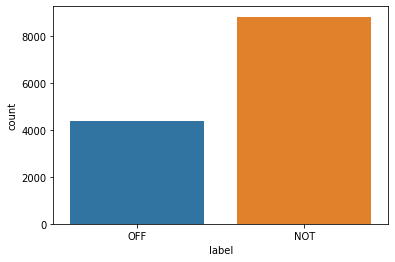

In [ ]:
# NUMBER 1 (Used for training)
olid_english = pd.read_csv(args['train_data_directory'] + 'olid-training-v1.0.tsv', sep ='\t')

# Change the name of the column containing the labels
olid_english = olid_english.rename({'subtask_a': 'label'}, axis = 1)

# Delete the unecessary columns
olid_english = olid_english.drop(columns=['id', 'subtask_b', 'subtask_c'], axis = 1)

print('Number of duplicates in the file:', olid_english.duplicated(subset = 'tweet').sum())
olid_english.drop_duplicates(subset = 'tweet', keep = 'first', inplace = True) 
 
print(olid_english.label.value_counts())
countplot_olid = sns.countplot(x = olid_english.label)
olid_english.head(10)

# Dataset found here: https://sites.google.com/site/offensevalsharedtask/olid

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/THESIS/train_files/labeled_data.csv']
Unnamed: 0                    24783
count                             5
hate_speech                       8
offensive_language               10
neither                          10
class                             3
tweet                         24783
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
Number of duplicates in the file: 0
OFF    20620
NOT     4

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,NOT
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,OFF
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,OFF
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,OFF
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,OFF
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",OFF
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",OFF
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,OFF
8,""" &amp; you might not get ya bitch back &amp; ...",OFF
9,""" @rhythmixx_ :hobbies include: fighting Maria...",OFF


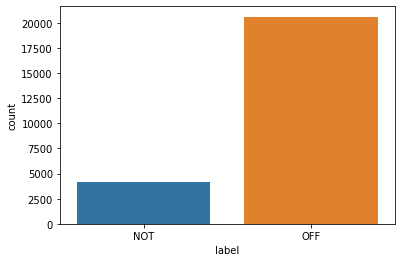

In [ ]:
# NUMBER 2 (Used for training) 
kaggle_dataset = read_a_file(args['train_data_directory'] + 'labeled_data.csv')

# Change the name of the column containing the labels and the name of the id column
kaggle_dataset = kaggle_dataset.rename({'class': 'label', 'Unnamed: 0': 'id'}, axis = 1)

# Delete the unecessary columns
kaggle_dataset  = kaggle_dataset.drop(columns = ['id', 'count', 'hate_speech','offensive_language', 'neither'], axis = 1)

kaggle_dataset['label'].replace({0: 1}, inplace = True)

# Replace the numeral labels with the respective categorical labels
kaggle_dataset['label'] = kaggle_dataset['label'].replace({1: 'OFF'})
kaggle_dataset['label'] = kaggle_dataset['label'].replace({2: 'NOT'})

# Change the order of the columns 
kaggle_dataset = kaggle_dataset.reindex(columns=['tweet', 'label'])

print('Number of duplicates in the file:', kaggle_dataset.duplicated(subset = 'tweet').sum())
kaggle_dataset.drop_duplicates(subset = 'tweet', keep = 'first', inplace = True) 

print(kaggle_dataset.label.value_counts())
countplot_train = sns.countplot(x = kaggle_dataset.label)
kaggle_dataset.head(10)
# Initial dataset labels: 0 - hate speech, 1 - offensive language, 2 - neither
# Dataset found here: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset/discussion/235251 

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/THESIS/train_files/FinalBalancedDataset.csv']
Unnamed: 0                    56745
Toxicity                          2
tweet                         54313
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56745 non-null  int64 
 1   Toxicity    56745 non-null  int64 
 2   tweet       56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.3+ MB
Number of duplicates in the file: 2432
NOT    30389
OFF    23924
Name: label, dtype: int64


,tweet,label
0,@user when a father is dysfunctional and is s...,NOT
1,@user @user thanks for #lyft credit i can't us...,NOT
2,bihday your majesty,NOT
3,#model i love u take with u all the time in ...,NOT
4,factsguide: society now #motivation,NOT
5,[2/2] huge fan fare and big talking before the...,NOT
6,@user camping tomorrow @user @user @user @use...,NOT
7,the next school year is the year for exams.ð...,NOT
8,we won!!! love the land!!! #allin #cavs #champ...,NOT
9,@user @user welcome here ! i'm it's so #gr...,NOT


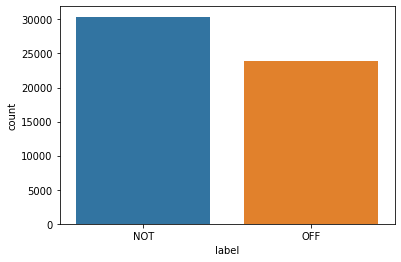

In [ ]:
# NUMBER 3 (Used for training) 
english_balanced_kaggle = read_a_file(args['train_data_directory'] + 'FinalBalancedDataset.csv')

# Change the name of the column containing the labels and the name of the id column
english_balanced_kaggle = english_balanced_kaggle.rename({'Toxicity': 'label', 'Unnamed: 0': 'id'}, axis = 1)

english_balanced_kaggle  = english_balanced_kaggle.drop(columns = ['id'], axis = 1)

english_balanced_kaggle['label'] = english_balanced_kaggle['label'].replace({1: 'OFF'})
english_balanced_kaggle['label'] = english_balanced_kaggle['label'].replace({0: 'NOT'})

# Change the order of the columns
english_balanced_kaggle = english_balanced_kaggle.reindex(columns=['tweet', 'label'])

print('Number of duplicates in the file:', english_balanced_kaggle.duplicated(subset = 'tweet').sum())
english_balanced_kaggle.drop_duplicates(subset = 'tweet', keep = 'first', inplace = True) 

print(english_balanced_kaggle.label.value_counts())
countplot_train_kaggle_tweets = sns.countplot(x = english_balanced_kaggle.label)
english_balanced_kaggle.head(10)
# Dataset found here: https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset 

In [ ]:
# Dataset found here: https://github.com/cardiffnlp/tweeteval

# It is named as 'article_english_train' below
'''
train_file = pd.read_csv('/content/train_text.txt', delimiter = '\t', header=None)
train_file.columns = ['tweet']

train_file_labels = pd.read_csv('/content/train_labels.txt', delimiter = '\t', header=None)
train_file_labels.columns = ['label']

train_dataset = pd.concat([train_file, train_file_labels], axis = 1)
train_dataset['label'] = train_dataset['label'].replace({1: 'OFF'})
train_dataset['label'] = train_dataset['label'].replace({0: 'NOT'})


val_file = pd.read_csv('/content/val_text.txt', delimiter = '\t', header=None)
val_file.columns = ['tweet']

val_file_labels = pd.read_csv('/content/val_labels.txt', delimiter = '\t', header=None)
val_file_labels.columns = ['label']

val_dataset = pd.concat([val_file, val_file_labels], axis = 1)
val_dataset['label'] = val_dataset['label'].replace({1: 'OFF'})
val_dataset['label'] = val_dataset['label'].replace({0: 'NOT'})

new_train_dataset = pd.concat([train_dataset, val_dataset], axis = 0)
new_train_dataset.to_csv('article_train_dataset.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')
'''

"\ntrain_file = pd.read_csv('/content/train_text.txt', delimiter = '\t', header=None)\ntrain_file.columns = ['tweet']\n\ntrain_file_labels = pd.read_csv('/content/train_labels.txt', delimiter = '\t', header=None)\ntrain_file_labels.columns = ['label']\n\ntrain_dataset = pd.concat([train_file, train_file_labels], axis = 1)\ntrain_dataset['label'] = train_dataset['label'].replace({1: 'OFF'})\ntrain_dataset['label'] = train_dataset['label'].replace({0: 'NOT'})\n\n\nval_file = pd.read_csv('/content/val_text.txt', delimiter = '\t', header=None)\nval_file.columns = ['tweet']\n\nval_file_labels = pd.read_csv('/content/val_labels.txt', delimiter = '\t', header=None)\nval_file_labels.columns = ['label']\n\nval_dataset = pd.concat([val_file, val_file_labels], axis = 1)\nval_dataset['label'] = val_dataset['label'].replace({1: 'OFF'})\nval_dataset['label'] = val_dataset['label'].replace({0: 'NOT'})\n\nnew_train_dataset = pd.concat([train_dataset, val_dataset], axis = 0)\nnew_train_dataset.to_csv('

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/THESIS/train_files/article_train_dataset.tsv']
tweet                         13202
label                             2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   13240 non-null  object
 1   label   13240 non-null  object
dtypes: object(2)
memory usage: 207.0+ KB
Number of duplicates in the file: 38
NOT    8808
OFF    4394
Name: label, dtype: int64


,tweet,label
0,@user Bono... who cares. Soon people will unde...,NOT
1,@user Eight years the republicans denied obama...,OFF
2,@user Get him some line help. He is gonna be j...,NOT
3,@user @user She is great. Hi Fiona!,NOT
4,@user She has become a parody unto herself? Sh...,OFF
5,@user @user @user @user @user @user @user @use...,NOT
6,@user Your looking more like a plant #maga #wa...,OFF
7,@user @user Lol. Except he’s the most successf...,NOT
8,@user Been a Willie fan since before most of y...,NOT
9,@user Here's a link to my channel with a pleth...,NOT


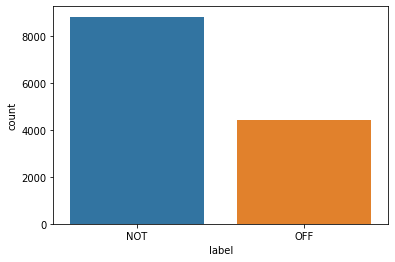

In [ ]:
# NUMBER 4 (Used for training) 
article_english_train = read_a_file(args['train_data_directory'] + 'article_train_dataset.tsv')

print('Number of duplicates in the file:', article_english_train.duplicated(subset = 'tweet').sum())
article_english_train.drop_duplicates(subset = 'tweet', keep = 'first', inplace = True) 

print(article_english_train.label.value_counts())
countplot_article_english_train = sns.countplot(x = article_english_train.label)
article_english_train.head(10)

**CREATE A BALANCED DATASET**

Number of duplicates in the file before dropping duplicates: 24783
Number of duplicates in the file after dropping duplicates: 0

Examples:
    Total: 80722
    Offensive (OFF-1): 32710 (40.52% of total)
    Not Offensive (NOT-0): 48012 (59.48% of total)

0    48012
1    32710
Name: label, dtype: int64


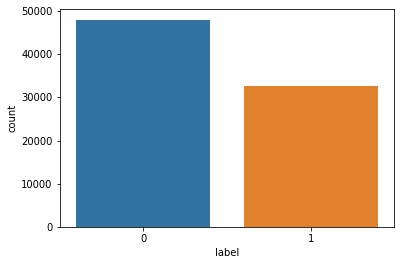

In [ ]:
# Concatenate the OLID English train dataset with the other 3 datasets to create a larger dataset 
english_train_dataset = pd.concat([olid_english, kaggle_dataset, english_balanced_kaggle, article_english_train], axis = 0)

# Replace the categorical values with numeral values for training 
english_train_dataset['label'].replace(labels, inplace = True)

print('Number of duplicates in the file before dropping duplicates:', english_train_dataset.duplicated(subset = 'tweet').sum())   
# Remove duplicate rows
english_train_dataset.drop_duplicates(subset = 'tweet', keep = 'last', inplace = True) 
print('Number of duplicates in the file after dropping duplicates:', english_train_dataset.duplicated(subset = 'tweet').sum())

# View and verify the balanced dataset 
not_offensive_tweets, offensive_tweets = english_train_dataset.label.value_counts()
total_tweets = not_offensive_tweets + offensive_tweets
print('\nExamples:\n    Total: {}\n    Offensive (OFF-1): {} ({:.2f}% of total)\n    Not Offensive (NOT-0): {} ({:.2f}% of total)\n'.format(total_tweets, offensive_tweets, 100 * offensive_tweets / total_tweets, not_offensive_tweets, 100 * not_offensive_tweets / total_tweets))

print(english_train_dataset.label.value_counts())
countplot_train_dataset = sns.countplot(x = english_train_dataset.label) 

**BALANCE THE DATASET**

Distribution of data in classes:
0    0.594782
1    0.405218
Name: label, dtype: float64
Distribution of data in classes after resampling:
0    32710
1    32710
Name: label, dtype: int64


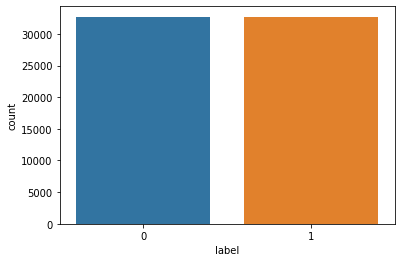

In [ ]:
# Check the distribution of classes
distribution = english_train_dataset.label.value_counts()/english_train_dataset.shape[0]
print('Distribution of data in classes:')
print(distribution)

# Separate the different labels and create a combined dataset
not_offensive = english_train_dataset[english_train_dataset['label'] == 0]
offensive = english_train_dataset[english_train_dataset['label'] == 1]

# Downsample the majority class (Not Offensive) 
not_offensive_downsampled = resample(not_offensive, 
                                     replace = False,               # Sample without replacement
                                     n_samples = len(offensive),    # to match the minority class
                                     random_state = 123)            # Get reproducible results
                    
# Combine in a new dataframe the new resampled classes 
english_train_dataset_resampled = pd.concat([not_offensive_downsampled, offensive], axis = 0) 

print('Distribution of data in classes after resampling:')
print(english_train_dataset_resampled.label.value_counts())
countplot_train_dataset = sns.countplot(x = english_train_dataset_resampled.label)
# The dataset is balanced!

In [ ]:
# View the balanced dataset
english_train_dataset_resampled[:50]

,tweet,label
9052,@user Haven't set any expectations on him... h...,0
14862,on the lookout for a new exciting hat. lemme k...,0
6115,@user I tear up from laughing so hard every si...,0
36128,@Morning_Joe If NBC has elected you to be a sp...,0
2437,when you tell yo bd you leaving his son here w...,0
12317,@user @user @user @user @user He could have ki...,0
10682,@USER @USER @USER @USER Source? Legit only. No...,0
23072,first conce for an extremely excited 9 year ol...,0
5218,@USER HAVE YOU NOTICED HOW RACIST THE MEDIA IS...,0
13655,are you ever unhappy with your job? here are 1...,0


**PREPROCESSED EXAMPLES OF DATA**

In [ ]:
preprocessing("#MAGA @USER 🎶 Sing like no one is listening ♥️ Love like you've never been hurt ✔️ Vote GOP when no one is watching 🙉 And don't listen to Liberals' dirt URL")

"<hashtag> maga </hashtag> musical notes sing like no one is listening heart suit love like you have never been hurt check mark vote gop when no one is watching hear no evil monkey and do not listen to liberals ' dirt"

In [ ]:
preprocessing("@USER URL url HTML html Canada 789 doesn’t doesn't need another CUCK! http://sentimentsymposium.com/")

'canada 789 does not does not need another cuck !'

In [ ]:
preprocessing("he knows me y'all! ðð this is why  233 trump")

'he knows me you all ! this is why 233 trump'

In [ ]:
preprocessing("!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...")

'! ! ! as a woman you should not complain about cleaning up your house . and as a man you should always take the trash out . . .'

In [ ]:
sent = "! ! ! ! as a woman you should not complain about cleaning up your house . and as a man you should always take the trash out . . ."

encoding = tokenizer.encode_plus(text = sent,
                                 text_pair = None,
                                 add_special_tokens = True,      # Add [CLS] and [SEP]
                                 max_length = 280,               # Max length to pad
                                 padding = 'max_length',         # Pad sentence according to max length  'max_length'
                                 truncation = True,              # Truncate the sentences
                                 return_token_type_ids = False,  # Do not return the ids of type tokens
                                 return_attention_mask = True,   # Return attention mask
                                 return_tensors = 'pt')  
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

280


tensor([  101,   999,   999,   999,   999,  2004,  1037,  2450,  2017,  2323,
         2025, 17612,  2055,  9344,  2039,  2115,  2160,  1012,  1998,  2004,
         1037,  2158,  2017,  2323,  2467,  2202,  1996, 11669,  2041,  1012,
         1012,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

280


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

**PREPARE THE TRAINING DATASET**

In [ ]:
# Apply preprocessing steps to the 'tweet' column of the undersampled balanced dataset
#english_train_dataset_resampled['tweet'] = english_train_dataset_resampled['tweet'].apply(lambda x: preprocessing(x))

# Divide the offensive from the not offensive tweets into different dataframes
#OFF = english_train_dataset_resampled[english_train_dataset_resampled['label'] == 1]
#NOT_OFFENSIVE_TWEETS_BALANCED = english_train_dataset_resampled[english_train_dataset_resampled['label'] == 0]

# Save the divided dataframes into separate tsv files
#OFF.to_csv(args['train_data_directory'] + 'OFF_balanced.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')
#NOT_OFFENSIVE_TWEETS_BALANCED.to_csv(args['train_data_directory'] + 'NOT_balanced.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

In [ ]:
#OFFENSIVE_TWEETS_BALANCED = select_to_get_offensive_words(args['train_data_directory'] + 'OFF_balanced.tsv', search_offensive_vocab = True)
#TRAINING_TWEETS_BALANCED = pd.concat([OFFENSIVE_TWEETS_BALANCED, NOT_OFFENSIVE_TWEETS_BALANCED], axis = 0)
#TRAINING_TWEETS_BALANCED.to_csv(args['train_data_directory'] + 'BALANCED_TRAINING_TWEETS.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')   

In [ ]:
# Apply preprocessing steps to the 'tweet' column of the whole unbalanced dataset
#english_train_dataset['tweet'] = english_train_dataset['tweet'].apply(lambda x: preprocessing(x))

# Divide the offensive from the not offensive tweets into different dataframes
#OFF_UNBALANCED = english_train_dataset[english_train_dataset['label'] == 1]
#NOT_OFFENSIVE_TWEETS_UNBALANCED = english_train_dataset[english_train_dataset['label'] == 0]

# Save the divided dataframes into separate tsv files
#OFF_UNBALANCED.to_csv(args['train_data_directory'] + 'OFF_unbalanced.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')
#NOT_OFFENSIVE_TWEETS_UNBALANCED.to_csv(args['train_data_directory'] + 'NOT_unbalanced.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

In [ ]:
#OFFENSIVE_TWEETS_UNBALANCED = select_to_get_offensive_words(args['train_data_directory'] + 'OFF_unbalanced.tsv', search_offensive_vocab = True) 
#TRAINING_TWEETS = pd.concat([OFFENSIVE_TWEETS_UNBALANCED, NOT_OFFENSIVE_TWEETS_UNBALANCED], axis = 0)
#TRAINING_TWEETS.to_csv(args['train_data_directory'] + 'UNBALANCED_TRAINING_TWEETS.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

In [15]:
# TWO TRAINING FILES: MY_UNBALANCED_TRAINING_TWEETS.tsv and  MY_BALANCED_TRAINING_TWEETS.tsv
training_dataset = read_a_file(args['train_data_directory'] + 'MY_UNBALANCED_TRAINING_TWEETS.tsv')
training_dataset.head(30)

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/THESIS/train_files/MY_UNBALANCED_TRAINING_TWEETS.tsv']
tweet                         67148
label                             2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80720 entries, 0 to 80719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   80720 non-null  object
 1   label   80720 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


,tweet,label
0,she should ask a few native americans what the...,1
1,go home you are drunk ! ! ! <hashtag> maga </h...,1
2,"someone should havetaken "" this piece of shit ...",1
3,liberals are all kookoo ! ! !,1
4,oh noes ! tough shit <OFF> .,1
5,was literally just talking about this lol all ...,1
6,canada does not need another cuck ! we already...,1
7,you are a lying corrupt traitor ! ! ! nobody w...,1
8,gun control ! that is all these kids are askin...,1
9,lol ! ! ! throwing the bullshit <OFF> flag on ...,1


In [16]:
social_tokenizer = SocialTokenizer(lowercase = False).tokenize  

sentences = [ [word for word in social_tokenizer(sent) if word.isalpha() or word.isdigit()] for sent in training_dataset.tweet.values]

counts = []
for sentence in sentences:
    counts.append(len(sentence))

# Takes the first two sequences of the list and adds then gets the next sequence and accumulates it until end of list.
def average_word_count(list_counts): 
    avg = reduce(lambda x, y: x + y, list_counts) / len(list_counts)
    return(avg)

print('Average number of words per sentence:', average_word_count(counts))

Average number of words per sentence: 16.27340188305253


In [ ]:
# Encode the concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens = True) for sent in training_dataset.tweet.values]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Maximum sentence length: ', max_len)

Maximum sentence length:  415


**SPLIT INTO TRAIN AND VALIDATIONS SETS & CREATE TRAIN AND VALIDATION DATALOADERS**

In [ ]:
train_dataloader, val_dataloader = TweetSplitDataPreparation(dataframe = training_dataset,
                                                             split_ratio = args['data_split_ratio'], 
                                                             tokenizer = tokenizer, 
                                                             max_length = args['max_seq_length'], 
                                                             batch_size = args['batch_size'], 
                                                             split_data = True, 
                                                             make_dataloaders = True)

**INSTANTIATE MODELS**

In [18]:
class ClassifierLastHiddenState(nn.Module):
    
  def __init__(self, pretrained_model, num_classes, config, dropout, freeze_bert = False):
    super(ClassifierLastHiddenState, self).__init__()
    
    self.pretrained_model = pretrained_model
    self.n_input = config.to_dict()['hidden_size']
    self.num_classes = num_classes  
    self.dropout = nn.Dropout(dropout)

    # Add dense layers to perform the classification
    self.classifier = nn.Linear(self.n_input, self.num_classes)

    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_bert:
      for param in self.pretrained_model.parameters():
        param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask, return_dict = False)
    #outputs = last_hidden_state, pooled_output

    # Extract the last hidden state of the token `[CLS]` for the classification task 
    last_hidden_state = outputs[0]
    cls_embeddings = last_hidden_state[:, 0]

    # Apply dropout
    dropout_output = self.dropout(cls_embeddings)
     
    # Feed input to classifier to compute logits
    final_output = self.classifier(dropout_output) 

    #Last Hidden State Output Shape: (12, 280, 1024) [batch size, max seq len, hidden size]
    #CLS Embeddings Output Shape: (12, 1024) [batch size, hidden size]
    #Final output Shape: (12, 1) [batch size, number of classes]

    return final_output  

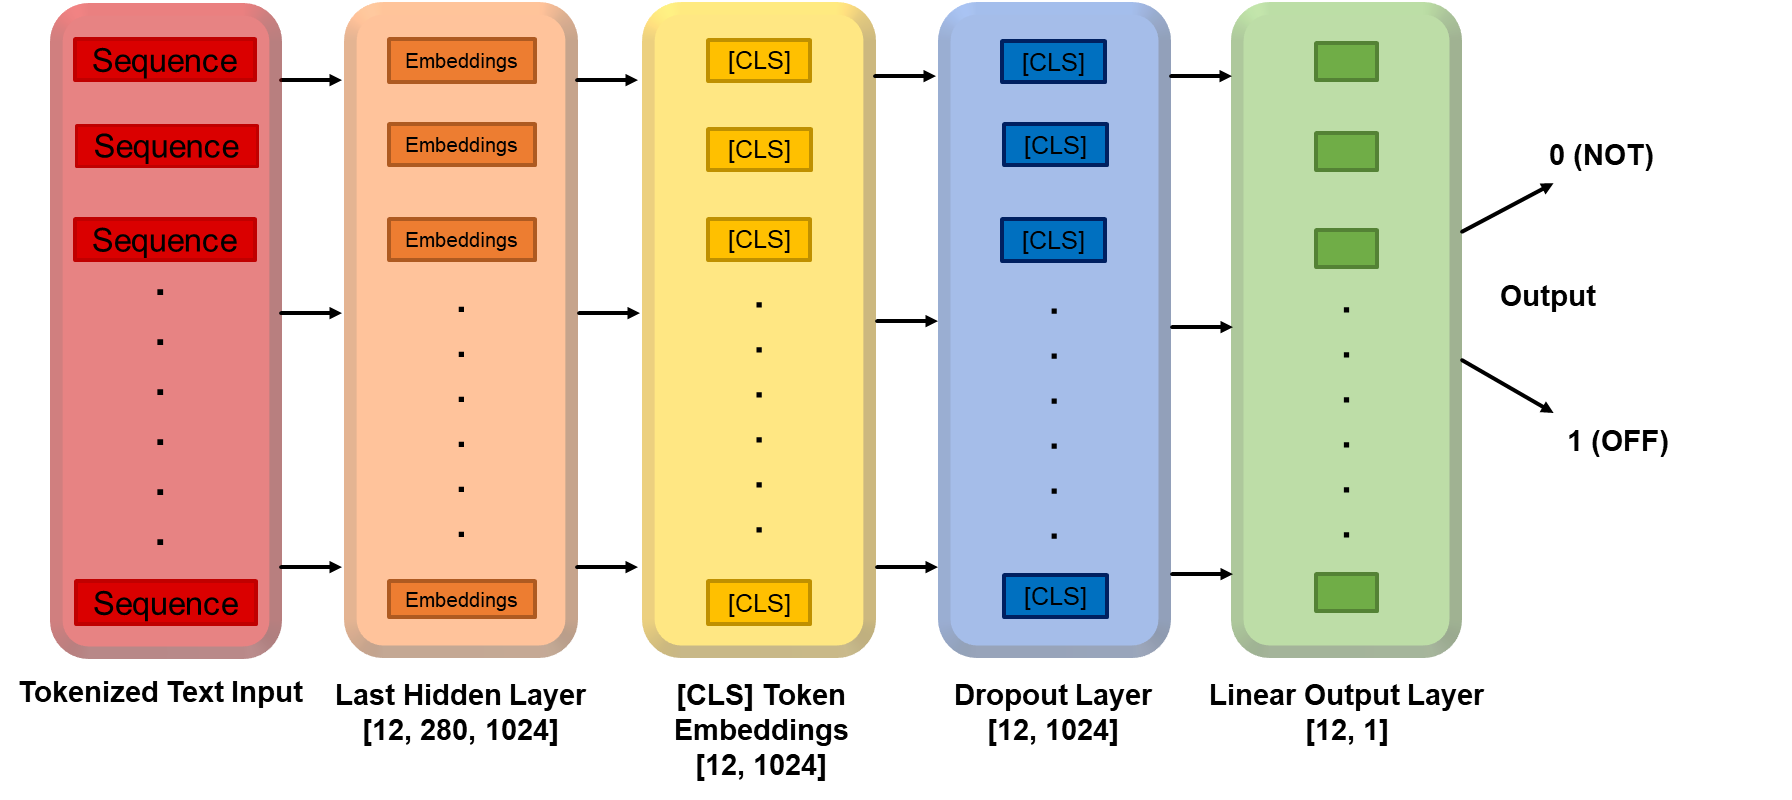

In [19]:
class ClassifierConcatLast4HiddenStates(nn.Module):
    
  def __init__(self, pretrained_model, num_classes, config, dropout, freeze_bert = False):
    super(ClassifierConcatLast4HiddenStates, self).__init__()
    
    self.pretrained_model = pretrained_model
    self.n_input = config.to_dict()['hidden_size']
    self.num_classes = num_classes  
    self.dropout = nn.Dropout(dropout)

    # Add dense layers to perform the classification 
    self.classifier = nn.Linear(self.n_input * 4, self.num_classes)

    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_bert:
      for param in self.pretrained_model.parameters():
        param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask, return_dict = False)
    
    # Concatenate the 4 last hidden layers
    all_hidden_states = torch.stack(outputs[2])   
    concatenate_pooling = torch.cat((all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]), dim = -1)
    last_hidden_state_cls = concatenate_pooling[:, 0]

    # Apply dropout
    dropout_output = self.dropout(last_hidden_state_cls)

    # Feed input to classifier to compute logits
    final_output = self.classifier(dropout_output)

    #print(f'Hidden States Output Shape: {all_hidden_states.shape}') #[25, 12, 280, 1024] [initial embeddings + 24 BERT layers, batch size, max seq len, hidden size]
    #print(f'Concatenate Pooling  Output Shape: {concatenate_pooling.shape}') #[12, 280, 4096 (1024 * 4)] [batch size, max seq len, hidden size * 4]
    #print(f'CLS Output Shape: {last_hidden_state_cls.shape}') #[12, 4096] [batch size, hidden size * 4]
    #print(f'Dropout Output Shape: {dropout_output.shape}') #[12, 4096] [batch size, hidden size * 4]
    #print(f'Logits Shape: {final_output.shape}') #[12, 1] [batch size, num of classes]

    return final_output 

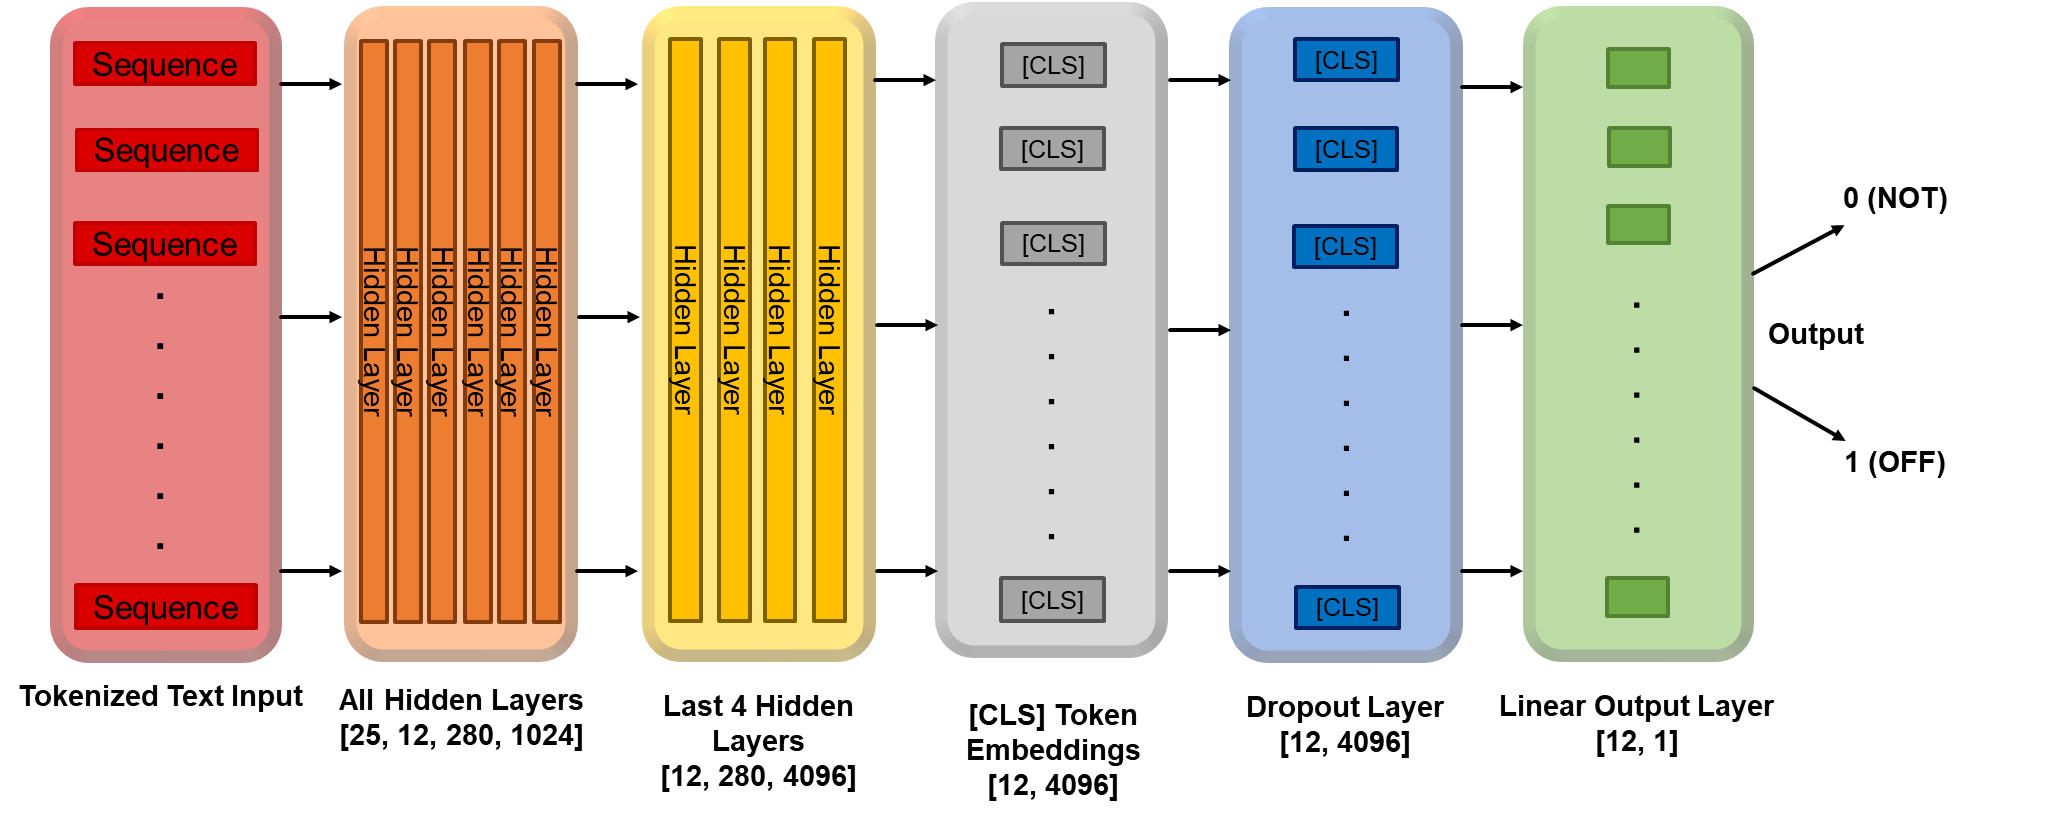

In [20]:
class BIDIRECTIONAL_RNN_LSTM_GRU(nn.Module):
  
  def __init__(self, cell_type, pretrained_model, config, num_classes, dropout, num_layers, seq_len, freeze_bert = False):             
    super(BIDIRECTIONAL_RNN_LSTM_GRU, self).__init__()

    cells = {'LSTM': nn.LSTM, 'GRU': nn.GRU}   

    # Initializations
    self.cell_type = cell_type
    self.pretrained_model = pretrained_model
    self.embedding_size = config.to_dict()['hidden_size']
    self.num_layers = num_layers
    self.num_classes = num_classes
    self.dropout = dropout
    self.sequence_length = seq_len
        
    assert cell_type in cells, 'Use one of the following: {}'.format(str(cells))
    rnn_cell = getattr(nn, cell_type)          # It fetches the constructor from torch.nn
    self.rnn = rnn_cell(
        input_size = self.embedding_size,      # Number of features for each time step        
        num_layers = self.num_layers,          # If the number of layers is bigger than 1, then it is a stacked RNN)
        hidden_size = self.sequence_length,    # Use the selected maximum sequence length needed in Bert
        batch_first = True,                    # Input and output's batch size: (batch, time_step, input_size) => 1st dimension
        bidirectional = True,                  # It is a bidirectional Recurrent Neural Network (RNN)
        dropout = self.dropout)                # Dropout regularization  
                              
    # Final hidden state has both a forward and a backward component concatenated together
    # The size of the input to the nn.Linear layer is twice that of the hidden dimension size
    self.predictor = nn.Linear(self.sequence_length * 2, self.num_classes) 

    # Initialize dropout layer for regularization
    self.dropout = nn.Dropout(dropout)
  
    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_bert:
      for param in self.pretrained_model.parameters():
        param.requires_grad = False
    
  def forward(self, input_ids, attention_mask):
  
    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

    all_hidden_states = torch.stack(outputs[2])
    
    hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze() for layer_i in range(1, config.num_hidden_layers+1)], dim=-1)
    hidden_states = hidden_states.view(-1, config.num_hidden_layers, self.embedding_size)

    if self.cell_type == 'LSTM':
      packed_output, _ = self.rnn(hidden_states, None) 
    if self.cell_type == 'GRU':
      packed_output, _ = self.rnn(hidden_states, None) 
    
    dropout_output = self.dropout(packed_output[:, -1, :])

    final_output = self.predictor(dropout_output)

    #print(f'All Hidden States Output Shape: {all_hidden_states.shape}') #[25, 12, 280, 1024] [initial embeddings + 24 BERT layers, batch size, max seq len, hidden size]
    #print(f'Hidden States Output Shape: {hidden_states.shape}') #[12, 24, 1024] [batch size, 24 BERT layers, hidden size]
    #print(f'Packed Output Shape: {packed_output.shape}') # [12 24 560] [batch size, 24 BERT layers, max seq len * 2]
    #print(f'LSTM Pooling Output Shape: {dropout_output.shape}') #[12, 560 (280 * 2)] [batch size, max seq len * 2]
    #print(f'Logits Shape: {final_output.shape}') # [12, 1] [batch size, output label shape]

    return final_output   

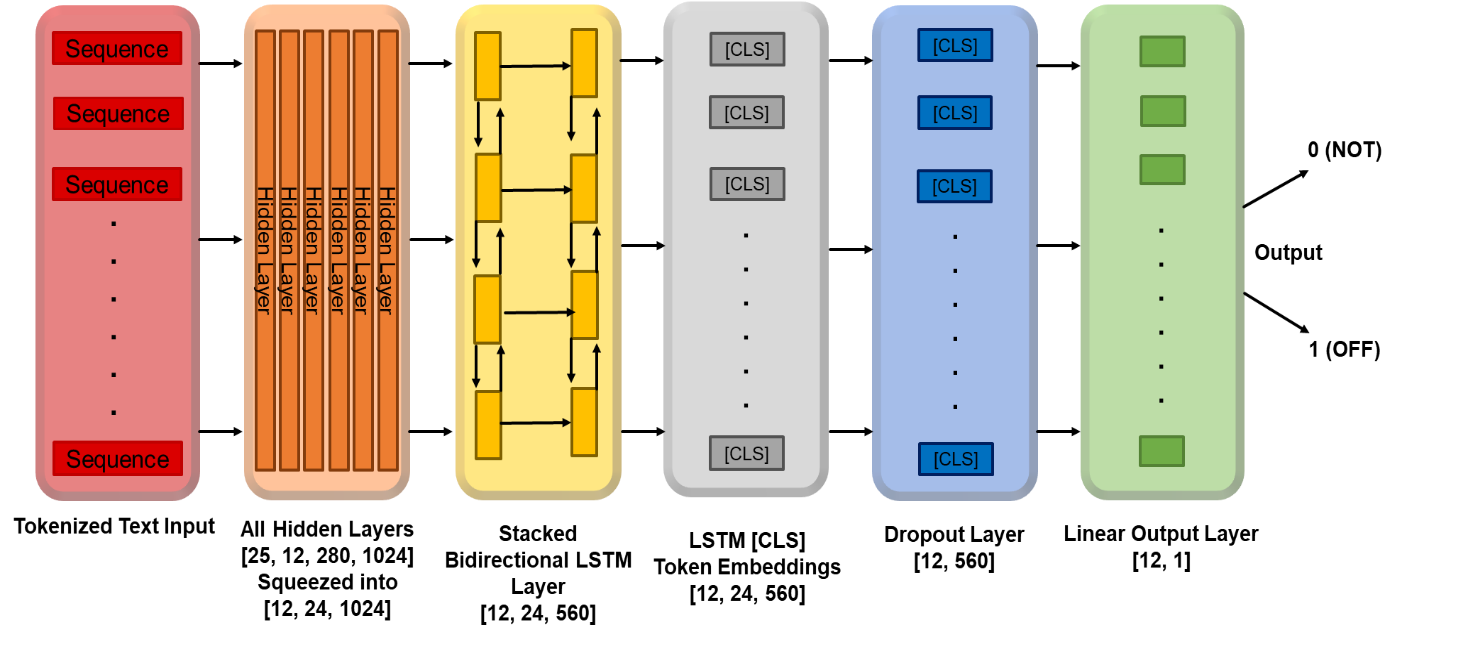

**INITIALIZE MODEL & ITS HYPERPARAMETERS**

In [29]:
# Uncomment the model you want to use

# Initialize the BERT Classifier with only the last hidden state
#model = ClassifierLastHiddenState(pretrained_model = the_pretrained_model, num_classes = args['num_classes'], config = config, dropout = args['dropout'], freeze_bert = False)

# Initialize the BERT Classifier by concatenating the last 4 hidden states
model = ClassifierConcatLast4HiddenStates(pretrained_model = the_pretrained_model, num_classes = args['num_classes'], config = config, dropout = args['dropout'], freeze_bert = False)

# Initialize the BERT Bi-Stacked-LSTM model 
#model = BIDIRECTIONAL_RNN_LSTM_GRU(cell_type = args['cell_type'], pretrained_model = the_pretrained_model, config = config, num_classes = args['num_classes'], dropout = args['dropout'], num_layers = args['num_layers'], seq_len = args['max_seq_length'], freeze_bert = False)

model.to(device)

# Total number of training steps
num_train_steps = int(len(train_dataloader) * args['num_train_epochs'])

# Define the optimizer and its parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = args['learning_rate'], eps = args['adam_epsilon'], betas=(0.9, 0.999))

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = args['warmup_steps'], num_training_steps = num_train_steps)

# Define the loss function
def loss_function(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)).to(device)

* `Training steps` are number of times the batches pass to train the model. It is computed as steps = (training epoch * examples)/batch size

* The `learning rate` is a positive scalar that determines the size of the step.When the learning rate is too large, the gradient descent can inadvertently increase rather than decrease the training error. When the learning rate is too small, training is slower and may become permanently stuck with a high training error.

* Warm-up is a way to reduce the primacy effect of the early training examples. Without it, you may need to run a few extra epochs to get the convergence desired, as the model un-trains those early superstitions. The learning rate is increased linearly over the warm-up period. If the target learning rate is p and the warm-up period is n, then the first batch iteration uses 1 * p/n for its learning rate; the second batch iteration uses 2 * p/n, and so on: iteration i uses i * p/n, until it hits the nominal rate at iteration n. Warm-up period is usually set to 1% of total training period.
`get_linear_schedule_with_warmup` creates a schedule with a learning rate that decreases linearly after linearly increasing during a warm-up period.

* `AdamW optimizer` implements Adam learning rate optimization algorithm. It is a type of Stochastic Gradient Descent with momentum. Here, momentum is described as the moving average of the gradient instead of gradient itself. 

* `Binary Cross Entropy Loss with Logits` combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.

In [ ]:
print('TRAINING PARAMETERS:\n')
print('Model Name: {}'.format(str(args['model_name'])))
print('The model has {:,} trainable parameters'.format(count_parameters(model)))
print('Loss function used: Binary Cross-Entropy Loss with Logits')
print('Optimizer used: AdamW')
print('Learning Rate: {:.5f}'.format(args['learning_rate']))
print('Adam Epsilon: {}'.format(args['adam_epsilon']))
print('Betas: {}'.format('0.9, 0.999'))
print('Weight Decay: {}'.format(args['weight_decay']))
print('Batch Size: {}'.format(args['batch_size']))
print('Number of training epochs: {}'.format(args['num_train_epochs']))
print('Maximum Sequence Length: {}'.format(args['max_seq_length']))
print('Bidirectional RNN Cell type: {}'.format(args['cell_type']))
print('Number of layers in the Bidirectional RNN: {}'.format(args['num_layers']))
print('Warm-up Steps: {}'.format(args['warmup_steps']))
print('Max grad Norm: {}'.format(args['max_grad_norm']))
print('Number of training steps: {}'.format(num_train_steps))
print('Dropout: {}'.format(args['dropout']))

In [ ]:
#print(model)

**TRAIN AND EVALUATE BERT MODEL (TRAIN & VALIDATION SETS)**

In [ ]:
print('Training model in {} sentences and evaluating model in {} sentences...'.format(len(train_dataloader), len(val_dataloader)))
# Store losses and accuracies
training_stats = []

# Define best_score, counter, and patience for early stopping:
best_score = None
counter = 0
patience = 3

model_filename = 'BERT.pt'
#'bert_large_classifier_slh_balanced.pt'


#'bert_large_classifier_a_h_st_balanced.pt'

# Measure the total training and evaluation time
total_t0 = time.time()

for epoch in range(0, args['num_train_epochs']):
  print('\n======== EPOCH {} / {} ========\n'.format(epoch + 1, args['num_train_epochs']))
  print('TRAINING MODEL...') 
    
  # Measure how long the training epoch takes
  t0 = time.time()

  training_loss = 0
  training_acc = 0  
    
  model.train()
    
  for step, batch in enumerate(tqdm(train_dataloader, desc = 'Training iteration')):

    # Progress update every 661 batches  482  349  927  727 457
    if step % 1000 == 0 and not step == 0:  
        
      # Calculate elapsed time in minutes
      elapsed = calculate_time(time.time() - t0)
              
      # Report progress
      print(f' Batch {step} of {len(train_dataloader)} | Elapsed time: {elapsed}') 
      
    input_ids = batch['input_ids'].to(device)   
    attention_masks = batch['attention_mask'].to(device) 
    labels = batch['label'].to(device)
    
    # Zero the gradients
    optimizer.zero_grad()
      
    # Perform forward propagation. Compute the predictions                            
    predictions = model(input_ids = input_ids, attention_mask = attention_masks)
                                                                       
    # Compute the loss  
    loss = loss_function(predictions, labels)

    # Compute the accuracy
    acc = accuracy(predictions, labels)

    # Move logits and labels to CPU
    predictions = predictions.detach().cpu().numpy()
    labels = labels.to('cpu').numpy()
      
    # Perform backward propagation
    loss.backward()

    # Clip the gradient value
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = args['max_grad_norm']) # Avoid exploding of gradients
      
    # Use optimizer to take gradient step and Update the learning rate
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
                      
    training_loss += loss.item()
    training_acc += acc.item()

  train_loss_of_epoch = training_loss / len(train_dataloader)
  train_accuracy_of_epoch = training_acc / len(train_dataloader)
          
  # Measure the epoch training time
  training_time = calculate_time(time.time() - t0)
    
  print('Training epoch time: {} | Train Loss: {:.3f} | Train Acc: {:.2f}%'.format(training_time, train_loss_of_epoch, train_accuracy_of_epoch*100))
    
  print('\nEVALUATING MODEL...')
    
  t0 = time.time()

  model.eval()  

  eval_loss = 0
  eval_acc = 0
    
  # Calculation of gradient not required during evaluation 
  with torch.no_grad():  
    
    for batch in tqdm(val_dataloader, desc = 'Evaluation iteration'):
      ids_inputs = batch['input_ids'].to(device)
      att_masks = batch['attention_mask'].to(device)
      targets = batch['label'].to(device)
      
      # Perform forward propagation
      outputs = model(input_ids = ids_inputs, attention_mask = att_masks)
        
      # Compute the loss 
      logits = loss_function(outputs, targets)

      # Compute the accuracy
      accur = accuracy(outputs, targets)
      
      # Move logits and labels to CPU
      outputs = outputs.detach().cpu().numpy()
      targets = targets.to('cpu').numpy()
          
      eval_loss += logits.item()
      eval_acc += accur.item()

  loss_of_epoch_val = eval_loss / len(val_dataloader)
  accuracy_of_epoch_val = eval_acc / len(val_dataloader)
  
  # Measure the validating epoch time
  validation_time = calculate_time(time.time() - t0)

  print('Validation epoch time: {} | Validation Loss: {:.3f} | Validation Acc: {:.2f}%'.format(validation_time, loss_of_epoch_val, accuracy_of_epoch_val*100))
  
  if best_score is None:
    best_score = loss_of_epoch_val
  else:
    # Check if val_loss improves or not.
    if loss_of_epoch_val < best_score:
      # val_loss improves, we update the latest best_score, and save the current model
      best_score = loss_of_epoch_val  
      save_model(model, model_filename, args['output_specific_model_dir'])  
    else:
      # val_loss does not improve, we increase the counter, stop training if it exceeds the amount of patience
      counter += 1
      if counter >= patience:
        print('EARLY STOPPING!')
        break

  # Record all statistics from each epoch
  training_stats.append({'Epoch': epoch + 1,
                         'Training Loss': train_loss_of_epoch,
                         'Validation Loss': loss_of_epoch_val,
                         'Training Accuracy': train_accuracy_of_epoch,
                         'Validation Accuracy': accuracy_of_epoch_val,
                         'Training Time': training_time,
                         'Validation Time': validation_time})
  
print('Training and evaluation process complete!')
print('Total amount of time: {}'.format(calculate_time(time.time()-total_t0)))

**SAVE THE TRAINED MODEL**

In [ ]:
save_model(model, 'BERT_CLASSIFIER_LAST4_HIDDEN.pt', args['output_specific_model_dir'])

In [ ]:
save_model(model, 'BERT_CLASSIFIER_LAST4_HIDDEN.pth', args['output_specific_model_dir'])

**VIEW THE RESULTS FROM TRAINING AND VALIDATION**

In [ ]:
# Display floats with two decimal places
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('Epoch')

# Display the table
df_stats

In [ ]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve of loss
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Validation Loss'], 'g-o', label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the learning curve of accuracy
plt.plot(df_stats['Training Accuracy'], 'b-o', label='Training')
plt.plot(df_stats['Validation Accuracy'], 'g-o', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**LOAD AND PREPARE THE TEST DATASETS**

**OLID TEST 2019**

0    620
1    240
Name: label, dtype: int64

Examples:
    Total: 860
    Not Offensive: 240 (27.91% of total)
    Offensive: 620 (72.09% of total)



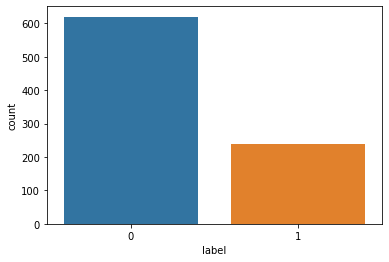

In [ ]:
olid_english_test_no_labels2019 = pd.read_csv(args['test_data_directory'] + 'testset-levela.tsv', sep = '\t')
olid_english_test_labels2019 = pd.read_csv(args['test_data_directory'] + 'labels-levela.csv', sep = ',',  names=['id_remove', 'label'])

olid_english_test_with_labels2019 = pd.concat([olid_english_test_no_labels2019, olid_english_test_labels2019], axis = 1)

olid_english_test_with_labels2019 = olid_english_test_with_labels2019.drop(columns=['id_remove','id'], axis = 1)

olid_english_test_with_labels2019['label'] = olid_english_test_with_labels2019['label'].replace({'OFF': 1})
olid_english_test_with_labels2019['label'] = olid_english_test_with_labels2019['label'].replace({'NOT': 0})

olid_english_test_with_labels2019['tweet'] = olid_english_test_with_labels2019['tweet'].apply(lambda x: preprocessing(x))

# Save the  combined test dataset in tsv form for evaluation
#olid_english_test_with_labels2019.to_csv(args['test_data_directory'] + 'olid_test_dataset_2019.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

print(olid_english_test_with_labels2019.label.value_counts())
countplot_train1 = sns.countplot(x = olid_english_test_with_labels2019.label)
 
not_offensive_tweets_t1, offensive_tweets_t1 = olid_english_test_with_labels2019.label.value_counts()
total_tweets_t1 = not_offensive_tweets_t1 + offensive_tweets_t1
print('\nExamples:\n    Total: {}\n    Not Offensive: {} ({:.2f}% of total)\n    Offensive: {} ({:.2f}% of total)\n'.format(total_tweets_t1, offensive_tweets_t1, 100 * offensive_tweets_t1 / total_tweets_t1, not_offensive_tweets_t1, 100 * not_offensive_tweets_t1 / total_tweets_t1))

In [ ]:
olid_2019_dataset = select_to_get_offensive_words(args['test_data_directory'] + 'olid_test_dataset_2019.tsv', search_offensive_vocab = False)            

Reading the file...
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/THESIS/test_files/olid_test_dataset_2019.tsv']
tweet                           848
label                             2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   860 non-null    object
 1   label   860 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.6+ KB


**OLID TEST 2020**

0    2807
1    1080
Name: label, dtype: int64

Examples:
    Total: 3887
    Not Offensive: 1080 (27.78% of total)
    Offensive: 2807 (72.22% of total)



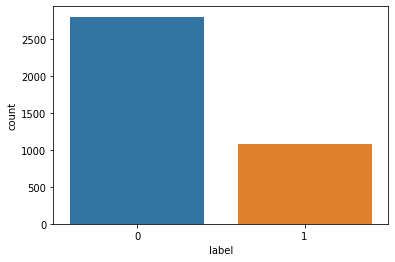

In [ ]:
olid_english_test_no_labels2020 = pd.read_csv(args['test_data_directory'] + 'test_a_tweets.tsv', sep = '\t')
olid_english_test_labels2020 = pd.read_csv(args['test_data_directory'] + 'englishA-goldlabels.csv', sep = ',',  names=['id_remove', 'label'])

olid_english_test_with_labels2020 = pd.concat([olid_english_test_no_labels2020, olid_english_test_labels2020], axis = 1)

olid_english_test_with_labels2020 = olid_english_test_with_labels2020.drop(columns=['id_remove','id'], axis = 1)

olid_english_test_with_labels2020['label'] = olid_english_test_with_labels2020['label'].replace({'OFF': 1})
olid_english_test_with_labels2020['label'] = olid_english_test_with_labels2020['label'].replace({'NOT': 0})

olid_english_test_with_labels2020['tweet'] = olid_english_test_with_labels2020['tweet'].apply(lambda x: preprocessing(x))

# Save the  combined test dataset in tsv form for evaluation
#olid_english_test_with_labels2020.to_csv(args['test_data_directory'] + 'olid_test_dataset_2020.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

print(olid_english_test_with_labels2020.label.value_counts())
countplot_train2 = sns.countplot(x = olid_english_test_with_labels2020.label)

not_offensive_tweets_t2, offensive_tweets_t2 = olid_english_test_with_labels2020.label.value_counts()
total_tweets_t2 = not_offensive_tweets_t2 + offensive_tweets_t2
print('\nExamples:\n    Total: {}\n    Not Offensive: {} ({:.2f}% of total)\n    Offensive: {} ({:.2f}% of total)\n'.format(total_tweets_t2, offensive_tweets_t2, 100 * offensive_tweets_t2 / total_tweets_t2, not_offensive_tweets_t2, 100 * not_offensive_tweets_t2 / total_tweets_t2))

In [ ]:
olid_2020_dataset = select_to_get_offensive_words(args['test_data_directory'] + 'olid_test_dataset_2020.tsv', search_offensive_vocab = False)         

Reading the file...
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/THESIS/test_files/olid_test_dataset_2020.tsv']
tweet                          3875
label                             2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   3887 non-null   object
 1   label   3887 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB


**OLID TEST 2019 + 2020**

0    3427
1    1320
Name: label, dtype: int64
Reading the file...
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/THESIS/test_files/test_combined_datasets_olid.tsv']
tweet                          4723
label                             2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747 entries, 0 to 4746
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   4747 non-null   object
 1   label   4747 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 74.3+ KB


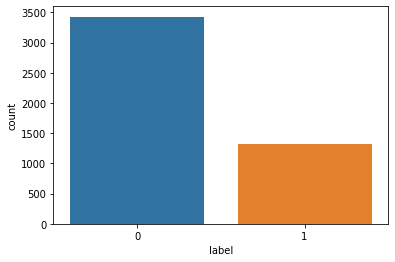

In [ ]:
# Combine the OLID 2019 and 2020 test sets and create a dataloader
test_combined_datasets_olid = pd.concat([olid_english_test_with_labels2019, olid_english_test_with_labels2020], axis = 0)
#test_combined_datasets_olid.to_csv(args['test_data_directory'] + 'test_combined_datasets_olid.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')

print(test_combined_datasets_olid.label.value_counts())
countplot_train_combined = sns.countplot(x = test_combined_datasets_olid.label)

test_combined_datasets = select_to_get_offensive_words(args['test_data_directory'] + 'test_combined_datasets_olid.tsv', search_offensive_vocab = False) 

**CREATE TEST DATALOADERS**

In [ ]:
# Dataloader for OLID 2019 test set
test_olid_dataloader_2019 = create_data_loader(df = olid_2019_dataset, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False)

# Dataloader for OLID 2020 test set
test_olid_dataloader_2020 = create_data_loader(df = olid_2020_dataset, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False)
print('Data OLID 2019 and 2020 ready for testing!')

# Dataloader for both OLID 2019 and OLID 2020 test sets 
test_combined_dataloader = create_data_loader(df = test_combined_datasets, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False)

Data OLID 2019 and 2020 ready for testing!


**MODEL EVALUATION ON THE TEST SETS**

In [ ]:
real_olid_2019_labels, predicted_olid_2019_labels = test(model, test_olid_dataloader_2019)

In [ ]:
real_olid_2020_labels, predicted_olid_2020_labels = test(model, test_olid_dataloader_2020)

In [ ]:
true_labels, predicted_labels = test(model, test_combined_dataloader)

**MAKE PREDICTIONS**

In [ ]:
loaded_model = load_saved_model(model, 'bert_classifier_concat_last_4_31419_balanced.pt', args['output_specific_model_dir'])

In [ ]:
input_text = 'You are a stupid asshole!'

input_text = preprocessing(input_text)

encoded_review = tokenizer.encode_plus(text = input_text,
                                        text_pair = None,
                                        add_special_tokens = True,      # Add [CLS] and [SEP]
                                        max_length = 280,               # Max length to pad
                                        padding = 'max_length',         # Pad sentence according to max length  'max_length'
                                        truncation = True,              # Truncate the sentences
                                        return_token_type_ids = False,  # Do not return the ids of type tokens
                                        return_attention_mask = True,   # Return attention mask
                                        return_tensors = 'pt')          # Return PyTorch tensor

class_names = ['NOT', 'OFF']

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {input_text}')
print(f'Label: {class_names[prediction]}')

**REFERENCE SOURCE CODES**

https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently
